In [1]:
push!(LOAD_PATH,"../../../ExoJulia/")
push!(LOAD_PATH,".")

4-element Array{ByteString,1}:
 "/Applications/Julia-0.4.5.app/Contents/Resources/julia/local/share/julia/site/v0.4"
 "/Applications/Julia-0.4.5.app/Contents/Resources/julia/share/julia/site/v0.4"      
 "../../../ExoJulia/"                                                                
 "."                                                                                 

In [2]:
using ExoJulia
using Optim

In [3]:
using PyPlot

# Read-in TTV data

In [4]:
ttv1_data = readdlm("../ttv_planet1.txt");
ttv2_data = readdlm("../ttv_planet2.txt");

In [5]:
# Reshape into 1d arrays
time1 = reshape(ttv1_data, length(ttv1_data));
time2 = reshape(ttv2_data, length(ttv2_data));

In [6]:
dt1 = time1[2:end] - time1[1:end-1];
dt2 = time2[2:end] - time2[1:end-1];

mdt1 = mean(dt1);
mdt2 = mean(dt2);

stdt1 = std(dt1);
stdt2 = std(dt2);

print("Inner planet period: ", mdt1, " +/- ", stdt1, "\n")
print("Outer planet period: ", mdt2, " +/- ", stdt2)

Inner planet period: 224.70076641863517 +/- 0.0022854502193227965
Outer planet period: 365.25630708152175 +/- 0.002178896306975526

# Plot data

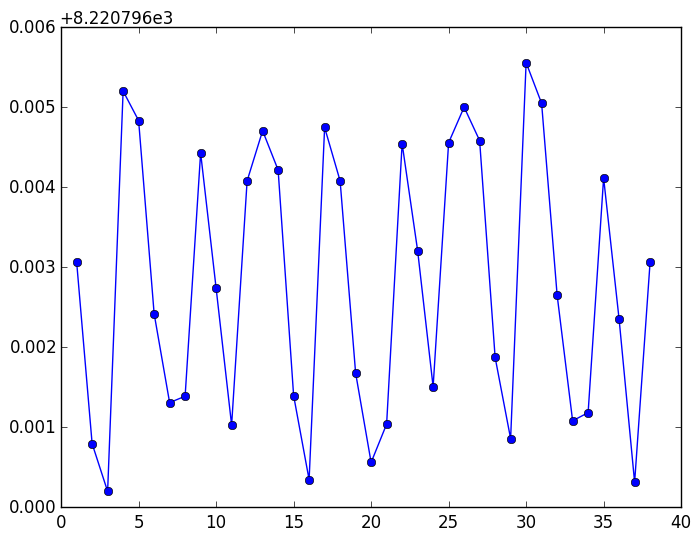

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x31e415790>

In [7]:
a1 = ones(length(time1))
b1 = zeros(length(time1))
for i=1:length(time1)
    a1[i] = i*mdt1
    b1[i] = i
end

plot(b1,time1 .- a1, "o-")

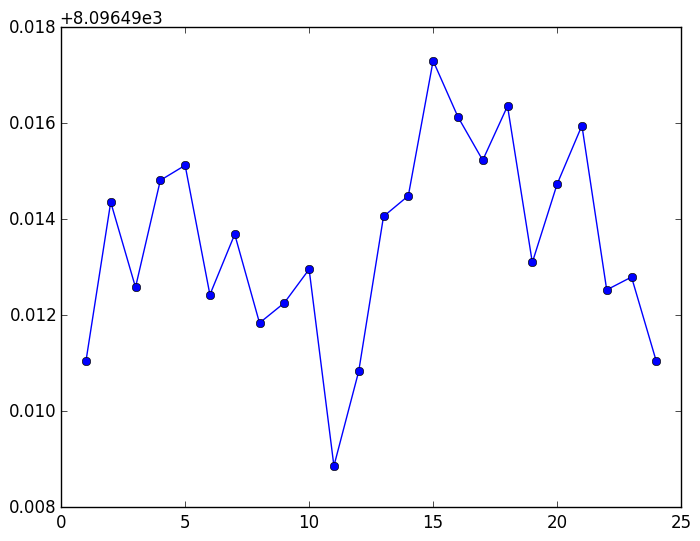

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x31de39890>

In [8]:
a2 = ones(length(time2))
b2 = zeros(length(time2))
for i=1:length(time2)
    a2[i] = i*mdt2
    b2[i] = i
end

plot(b2,time2 .- a2, "o-")

# Wrapper for `compute_ttv.jl`

In [9]:
include("../compute_ttv.jl")

TTVFaster

In [58]:
function ttv_model(time1::Array{Float64, 1}, time2::Array{Float64, 1}, params::Vector)
    
    # Planet 1 params
    MpMs1 = params[1]
    P1    = params[2]
    t01   = params[3]
    esw1  = params[4]
    ecw1  = params[5]
    
    # Planet 2 params
    MpMs2 = params[6]
    P2    = params[7]
    t02   = params[8]
    esw2  = params[9]
    ecw2  = params[10]
    
    # System params
    jmax  = 3 #params[11] 
    
    # Create Planet type for inner planet
    planet1 = TTVFaster.Planet_plane_hk(MpMs1, P1, t01, esw1, ecw1)
    
    # Create Planet type for outer planet
    planet2 = TTVFaster.Planet_plane_hk(MpMs2, P2, t02, esw2, ecw2)
    
    # Allocate memory for ttv's
    ttv1 = zeros(length(time1));
    ttv2 = zeros(length(time2));
    
    # Call compute_ttv! Note: modifies ttv1, ttv2 in place
    TTVFaster.compute_ttv!(jmax, planet1, planet2, time1, time2, ttv1, ttv2)

    return ttv1, ttv2
end 

ttv_model (generic function with 1 method)

In [11]:
#planet1
MpMs1 = 0.001
P1 = mdt1
t01 = 1.0
esw1 = 0.1
ecw1 = 0.1

#planet2
MpMs2 = 0.001
P2 = mdt2
t02 = 1.0
esw2 = 0.1
ecw2 = 0.1

p0 = [MpMs1,P1,t01,esw1,ecw1,MpMs2,P2,t02,esw2,ecw2];

In [12]:
ttv1, ttv2 = ttv_model(time1, time2, p0);

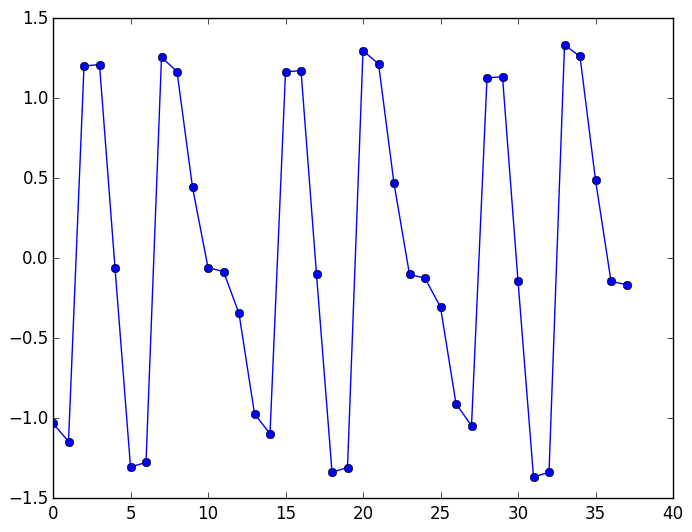

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x308770350>

In [13]:
plot(ttv1, "o-")

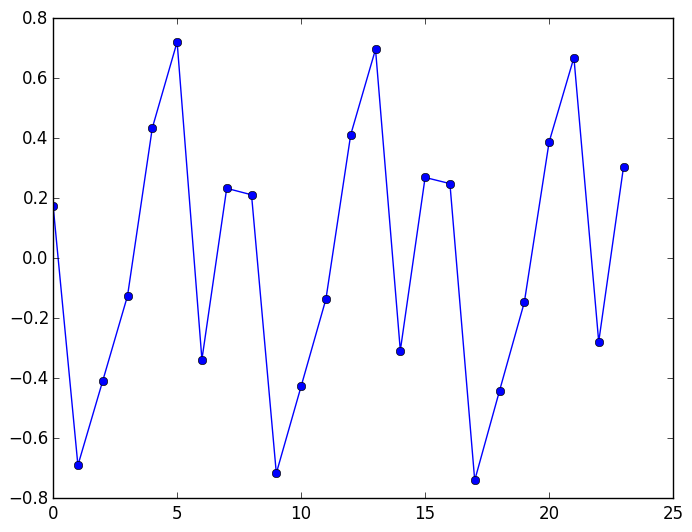

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x308876b90>

In [14]:
plot(ttv2, "o-")

# Let's checkout `aimee`

In [17]:
include("aimee.jl")

est_burnin (generic function with 1 method)

In [65]:
function lnlike(data::Array{Float64,2},model::Function,params::Vector)
    # params = [MpMs1,P1,t01,esw1,ecw1,MpMs2,P2,t02,esw2,ecw2];

    # Zero masks
    mask1 = data[:,1] .> 0.0
    mask2 = data[:,2] .> 0.0
    
    # Extract arrays from data matrix
    time1 = data[mask1,1]
    time2 = data[mask2,2]
    
    # --- Hard-Bounds ---
    # Masses > 0
    if (params[1] < 0.0) || (params[6] < 0.0)
        return Inf
    end
    # Periods > 0
    if (params[2] < 0.0) || (params[7] < 0.0)
        return Inf
    end
    # -1 < esin(w) & ecos(w) < 1
    if (params[4] < -1.0) || (params[4] > 1.0) || (params[5] < -1.0) || (params[5] > 1.0)
        return Inf
    end
    if (params[9] < -1.0) || (params[9] > 1.0) || (params[10] < -1.0) || (params[10] > 1.0)
        return Inf
    end
    
    # Call model
    ttv1, ttv2 = model(time1, time2, params);
    
    # Compute sum-square-diffs
    res = 0
    res += sum((time1 .- ttv1).^2)
    res += sum((time2 .- ttv2).^2)
        
    return res
end

lnlike (generic function with 1 method)

In [56]:
function molded_by_it(t1, t2)
    if length(t1) > length(t2)
        N = length(t1)
        n = length(t2)
        x = t1
        y = t2
    else
        N = length(t2)
        n = length(t1)
        x = t2
        y = t1
    end
    
    dat = zeros(N)
    
    for i=1:n
        dat[i] = y[i]
    end
    
    # Preserve order
    if length(t1) > length(t2)
        data = [x dat]
    else
        data = [dat x]
    end
    
    return data
end

molded_by_it (generic function with 1 method)

In [57]:
data_in = molded_by_it(time1, time2);

In [63]:
function fit_model(nsteps::Int,in_data::Array{Float64,2};
    verbose::Bool=true)
    
    global data = in_data
    
    params = [MpMs1,P1,t01,esw1,ecw1,MpMs2,P2,t02,esw2,ecw2];
    errors = [0.0005, 1.0, 1.0, 0.1, 0.1,0.0005, 1.0, 1.0, 0.1, 0.1]
    

    return affine_inv_mcmc(nsteps,params,ttv_model,errors,verbose=verbose,lnlike=lnlike)
end

fit_model (generic function with 1 method)

In [70]:
N = 1000000
pb, ll, nw, np = fit_model(N, data_in; verbose=false)

(
30x1000000x10 Array{Float64,3}:
[:, :, 1] =
 0.000492285  0.000492285  0.000492285  …  0.00219698   0.00219698 
 0.000948667  0.000948667  0.000948343     0.00336462   0.00336462 
 0.000838283  0.000838283  0.000838283     0.00529115   0.00529115 
 0.00089574   0.00089574   0.00089574      0.00212573   0.00212573 
 0.00156312   0.00156312   0.00156312      0.00489978   0.00489978 
 0.00183335   0.00183335   0.00185363   …  0.00531249   0.00531249 
 0.00196533   0.00196533   0.00196533      0.00212889   0.00212889 
 0.00109946   0.00109946   0.00109946      0.00336591   0.00336591 
 0.00101502   0.00103077   0.00103077      0.00194228   0.00194228 
 0.000849039  0.00138582   0.00138582      0.00213223   0.00213223 
 0.00126522   0.00126522   0.00126522   …  0.00646299   0.00646299 
 0.00125096   0.0013398    0.0013398       0.00489977   0.00489977 
 0.0022053    0.00211067   0.00211067      0.00578416   0.00578416 
 ⋮                                      ⋱                          
 0

In [72]:
iburn = est_burnin(pb, nw, np, N)

1000000

In [74]:
pavg = mean(vec(pb[1:nw,iburn:N,1]));
psig = std(vec(pb[1:nw,iburn:N,1]));
@printf "MpMs1: %8.4f +/- %8.4f\n" pavg psig

MpMs1:   0.0038 +/-   0.0017


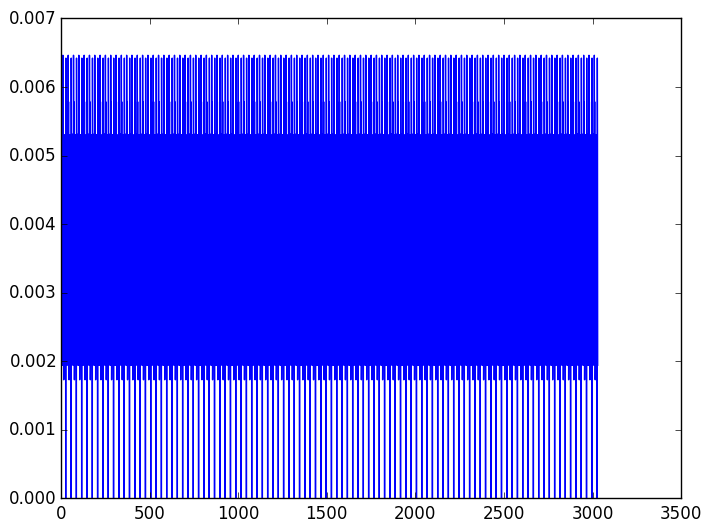

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x43feeb310>

In [102]:
NN = Int(0.9999*N)
plot(vec(pb[1:nw,NN:end,1]))

In [ ]:
""